# Modèle de Prévision ( XG Boost )

Dans ce notebook, nous allons tenter de faire de la prévision avec le logiciel XG boost

In [189]:
## Installation des packages nécessaires
import numpy as np  
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing 
import sklearn.metrics
from sklearn.metrics import mean_squared_error, r2_score
import datetime
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


## Partie 1  : preprocessing

In [73]:
def create_bdd(nom_court,kva):
    df = pd.read_csv("/Users/jeremiedarracq/Stat-app/data_one_hot_encoded_heure_mois_"+kva+"_"+nom_court+".csv")
    df = df.drop(["mois","region_x","total_energie_soutiree_wh","indice","mois_1","mois_2","mois_3","mois_4","mois_5","mois_6","mois_7","mois_8","mois_9","mois_10","mois_11","mois_12","heure_1","heure_2","heure_3","heure_4","heure_5","heure_6","heure_7","heure_8","heure_9","heure_10","heure_11","heure_12","heure_13","heure_14","heure_15","heure_16","heure_17","heure_18","heure_19","heure_20","heure_21","heure_22","heure_23","heure_24","heure_25","heure_26","heure_27","heure_28","heure_29","heure_30","heure_31","heure_32","heure_33","heure_34","heure_35","heure_36","heure_37","heure_38","heure_39","heure_40","heure_41","heure_42","heure_43","heure_44","heure_45","heure_46","heure_47","heure_48"],axis=1)
    df["horodate"] = df["date"] + df["heure"]
    df = df.drop(["date","heure"],axis=1)
    split_date = "2021-06-04"
    df_train = df.loc[df["horodate" ]< split_date].copy()
    df_test = df.loc[df["horodate" ]> split_date].copy()
    df_train["horodate"]=df_train["horodate"].apply(lambda x : x[0:16])
    df_test["horodate"]=df_test["horodate"].apply(lambda x : x[0:16])
    df_test["horodate"] = df_test["horodate"].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d%H:%M"))
    df_train["horodate"] = df_train["horodate"].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d%H:%M"))
    return df_train,df_test


In [82]:
enedis_IDF_train, enedis_IDF_test = create_bdd("IDF","6kva")
enedis_HDF_train, enedis_HDF_test = create_bdd("HDF","6kva")
enedis_PACA_train, enedis_PACA_test = create_bdd("PACA","6kva")

In [196]:
def verif_lag(df_train,nom_court):
    plot_acf(df_train["res_conso_moyenne"])
    plt.title("ACF pour la region"+nom_court)
    plot_pacf(df_train["res_conso_moyenne"])
    plt.title("PACF pour la region"+nom_court)
    

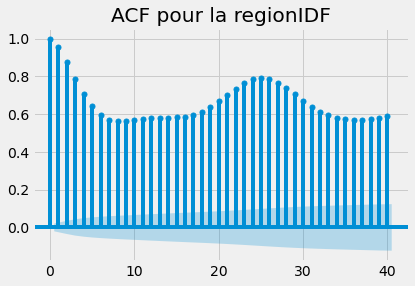

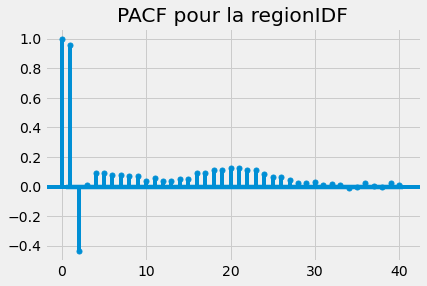

In [197]:
verif_lag(enedis_IDF_train,"IDF")

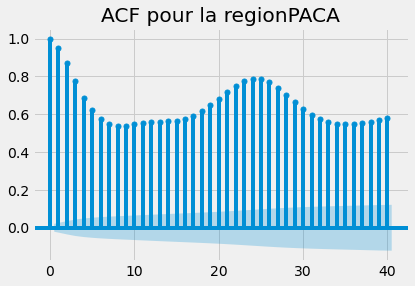

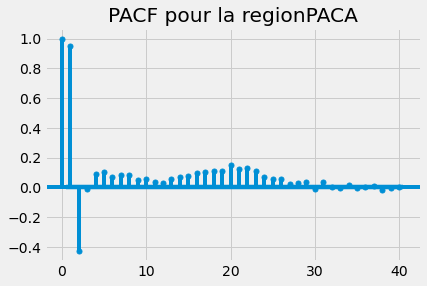

In [199]:
verif_lag(enedis_PACA_train,"PACA")

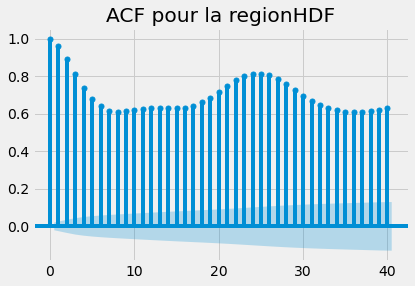

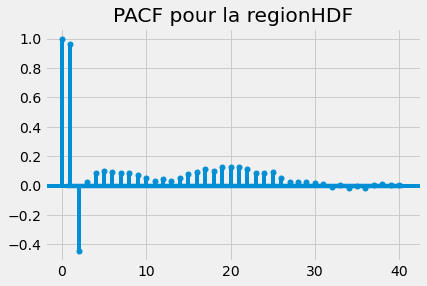

In [200]:
verif_lag(enedis_HDF_train,"HDF")

In [295]:
## Création des features de notre modèle

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['horodate'].dt.hour
    df['dayofweek'] = df['horodate'].dt.dayofweek
    df['month'] = df['horodate'].dt.month
    df['dayofyear'] = df['horodate'].dt.dayofyear
    df['dayofmonth'] = df['horodate'].dt.day
    df["minute"] = df["horodate"].dt.minute
    df['conso_lag_1'] = df['res_conso_moyenne'].shift(1)
    df['conso_lag_2'] = df['res_conso_moyenne'].shift(2)
    df['conso_lag_3'] = df['res_conso_moyenne'].shift(3)
    df['conso_lag_4'] = df['res_conso_moyenne'].shift(4)
    df['conso_lag_22'] = df['res_conso_moyenne'].shift(22)
    df["conso_lag_23"] = df['res_conso_moyenne'].shift(23)
    df['conso_lag_24'] = df['res_conso_moyenne'].shift(24)
    df['conso_lag_25'] = df['res_conso_moyenne'].shift(25)
    df['conso_6_hrs_mean'] = df['res_conso_moyenne'].rolling(window = 12).mean()
    df['conso_12_hrs_mean'] = df["res_conso_moyenne"].rolling(window = 24).mean()
    df["conso_6_hrs_std"] = df['res_conso_moyenne'].rolling(window = 12).std()
    df['conso_12_hrs_std'] = df["res_conso_moyenne"].rolling(window = 24).std()
    df['conso_6_hrs_max'] = df['res_conso_moyenne'].rolling(window = 12).max()
    df['conso_12_hrs_max'] = df['res_conso_moyenne'].rolling(window = 24).max()
    df['conso_6_hrs_min'] = df['res_conso_moyenne'].rolling(window = 12).min()
    df['conso_12_hrs_min'] = df["res_conso_moyenne"].rolling(window = 24).min()

    X = df[["hour","dayofweek","minute","month","dayofyear","dayofmonth","weekofyear","tmoy","conso_lag_1" ,"conso_lag_2","conso_lag_3","conso_lag_4","conso_lag_22","conso_lag_23","conso_lag_24","conso_lag_25","conso_6_hrs_mean","conso_12_hrs_mean",'conso_6_hrs_std','conso_12_hrs_std','conso_6_hrs_max',"conso_12_hrs_max","conso_6_hrs_min","conso_12_hrs_min"]]
    if label:
        y = df[label]
        return X, y
    return X

def train_test_split(df_train,df_test):
    X_train, y_train = create_features(df_train, label='res_conso_moyenne')
    X_test, y_test = create_features(df_test, label='res_conso_moyenne')
    return X_train, X_test , y_train , y_test


In [296]:
X_IDF_train , X_IDF_test , y_IDF_train , y_IDF_test = train_test_split(enedis_IDF_train,enedis_IDF_test)
X_HDF_train , X_HDF_test , y_HDF_train , y_HDF_test = train_test_split(enedis_HDF_train,enedis_HDF_test)
X_PACA_train , X_PACA_test , y_PACA_train, y_PACA_test = train_test_split(enedis_PACA_train,enedis_PACA_test)

## Parte 2 : Execution d'XG Boost

In [297]:
def xg_boost_results(df_train,df_test,X_train,X_test,y_train,y_test,nom_court):
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)
    plot_importance(reg, height=0.9)
    plt.title("feature importance de la Region"+ nom_court)
    df_test['Conso_prediction'] = reg.predict(X_test)
    enedis_all = pd.concat([df_train, df_test], sort=False)
    enedis_all[['res_conso_moyenne','Conso_prediction']].plot(figsize=(15, 5))
    plt.title("Prévision de la variation de la consommation éléctrique moyenne par contrat pour la région"+nom_court)
    MSE = mean_squared_error(y_true=df_test['res_conso_moyenne'],y_pred=df_test['Conso_prediction'])
    MSE_combine = "le MSE est de" + str(MSE)
    print(MSE_combine)
    r2 = r2_score(y_true=df_test['res_conso_moyenne'],y_pred=df_test['Conso_prediction'])
    r2_combine = "le R2 est de " + str(r2)
    print (r2_combine)


/Users/jeremiedarracq/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


le MSE est de35.89306934902792
le R2 est de 0.9779273171612404


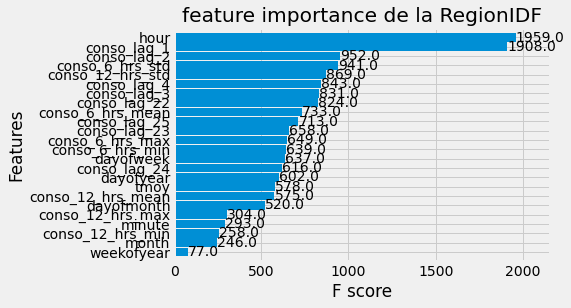

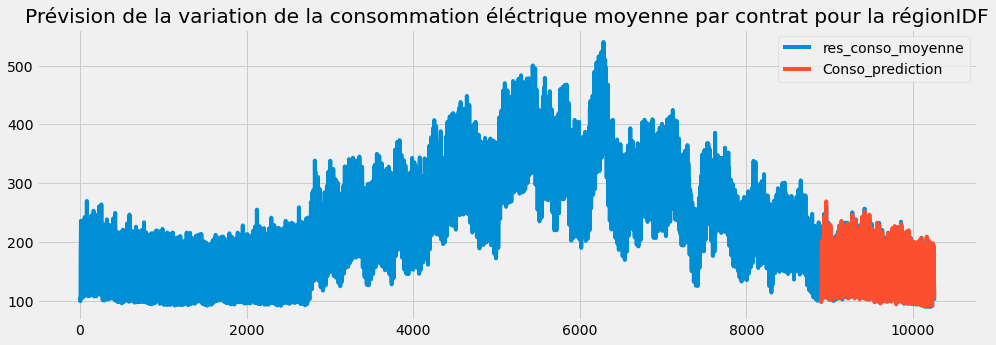

In [298]:
xg_boost_results(enedis_IDF_train,enedis_IDF_test,X_IDF_train,X_IDF_test,y_IDF_train,y_IDF_test,"IDF")


/Users/jeremiedarracq/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


le MSE est de63.67074531691058
le R2 est de 0.9714771536953238


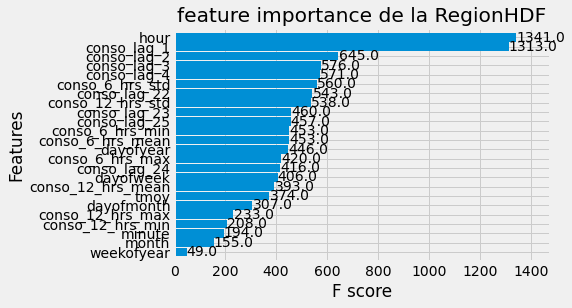

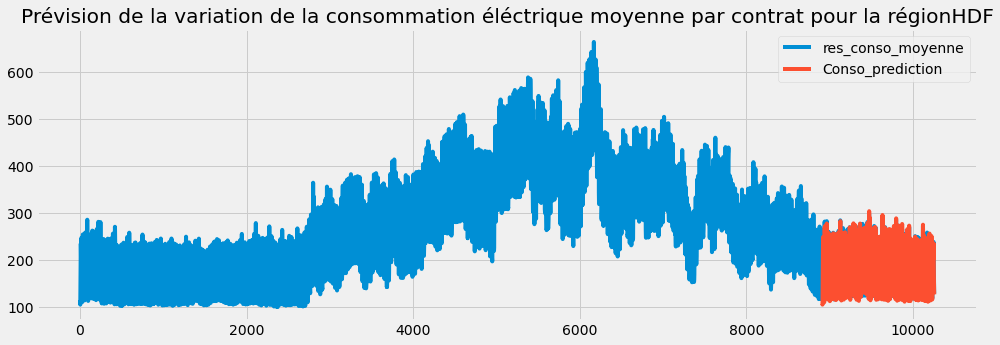

In [299]:
xg_boost_results(enedis_HDF_train,enedis_HDF_test,X_HDF_train,X_HDF_test,y_HDF_train,y_HDF_test,"HDF")


/Users/jeremiedarracq/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


le MSE est de67.96855335544406
le R2 est de 0.9749729651492114


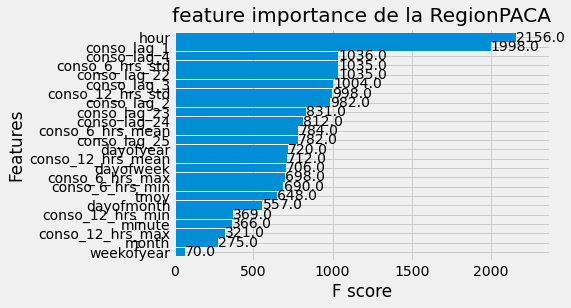

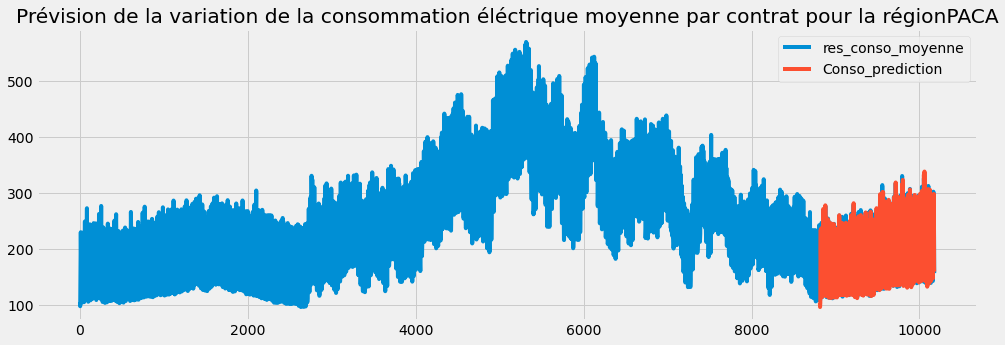

In [300]:
xg_boost_results(enedis_PACA_train,enedis_PACA_test,X_PACA_train,X_PACA_test,y_PACA_train,y_PACA_test,"PACA")


In [301]:
def xg_boost_molaire(df_train,df_test,nom_court):
    df_test['error'] = df_test['res_conso_moyenne'] - df_test['Conso_prediction']
    df_test['abs_error'] = df_test['error'].apply(np.abs)
    error_by_day = df_test.groupby(['month','dayofmonth',"dayofyear"]).mean()[["res_conso_moyenne","Conso_prediction","error","abs_error"]]
    df_best_error = error_by_day.sort_values('abs_error', ascending=True).reset_index()
    df_worst_error = error_by_day.sort_values('abs_error', ascending=False).reset_index()
    df_best_predicted_day = df_test[df_test["dayofyear"]==df_best_error["dayofyear"][0]]
    df_worst_predicted_day = df_test[df_test["dayofyear"]==df_worst_error["dayofyear"][0]]
    # Best predicted day
    plt.figure(figsize=(20,6))
    plt.plot(df_best_predicted_day["hour"],df_best_predicted_day["res_conso_moyenne"],label="observations")
    plt.scatter(df_best_predicted_day["hour"],df_best_predicted_day["Conso_prediction"],label="predictions",color="red")
    plt.xlabel("date")
    plt.ylabel("Wh")
    plt.title("Best Predicted day pour la région"+nom_court)
    plt.legend()
    ## Worst predicted day
    plt.figure(figsize=(20,6))
    plt.plot(df_worst_predicted_day["hour"],df_worst_predicted_day["res_conso_moyenne"],label="observations")
    plt.scatter(df_worst_predicted_day["hour"],df_worst_predicted_day["Conso_prediction"],label="predictions",color="red")
    plt.xlabel("heure")
    plt.ylabel("Wh")
    plt.title("Worst predicted day pour la région"+nom_court)
    plt.legend()
    

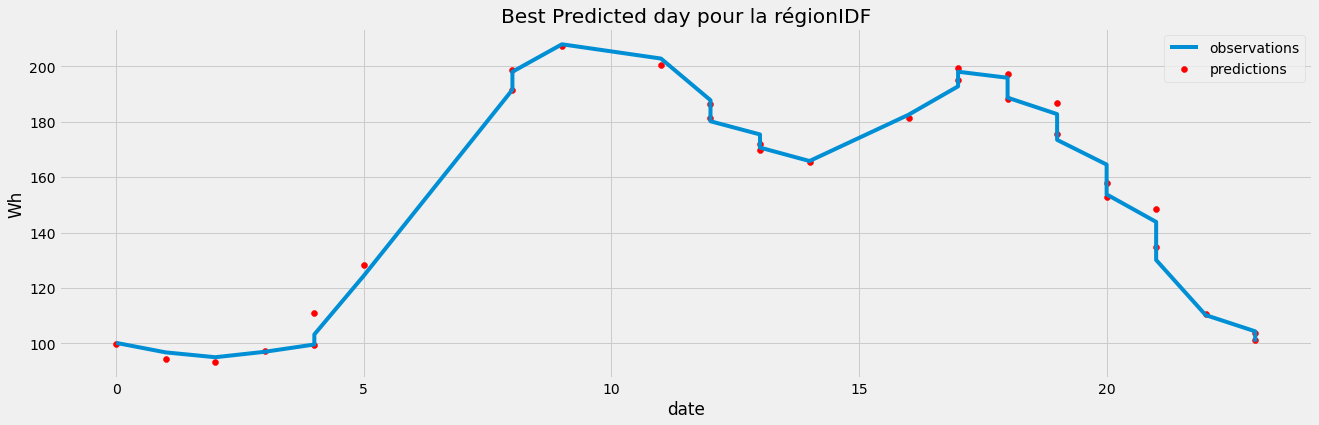

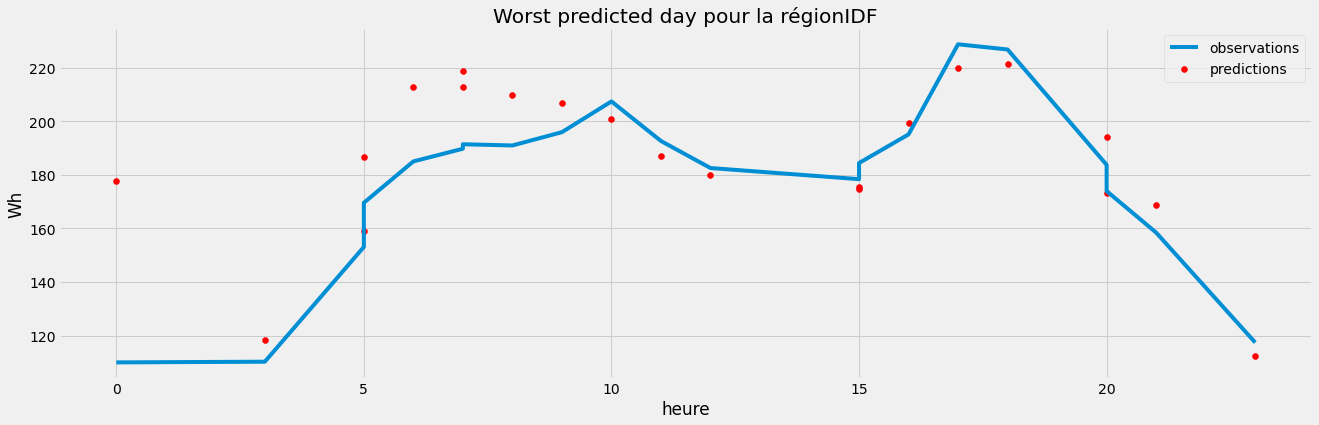

In [302]:
xg_boost_molaire(enedis_IDF_train,enedis_IDF_test,"IDF")


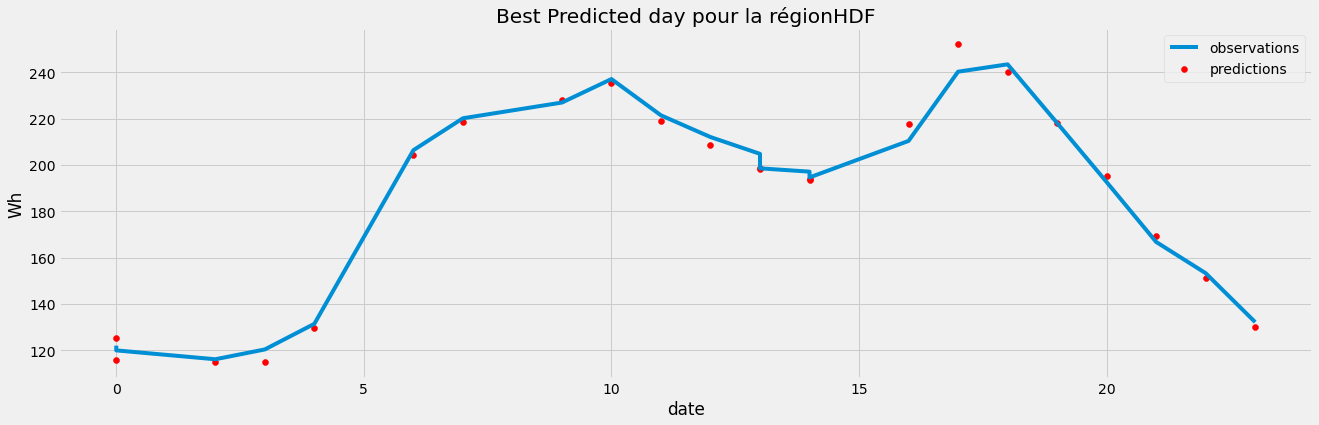

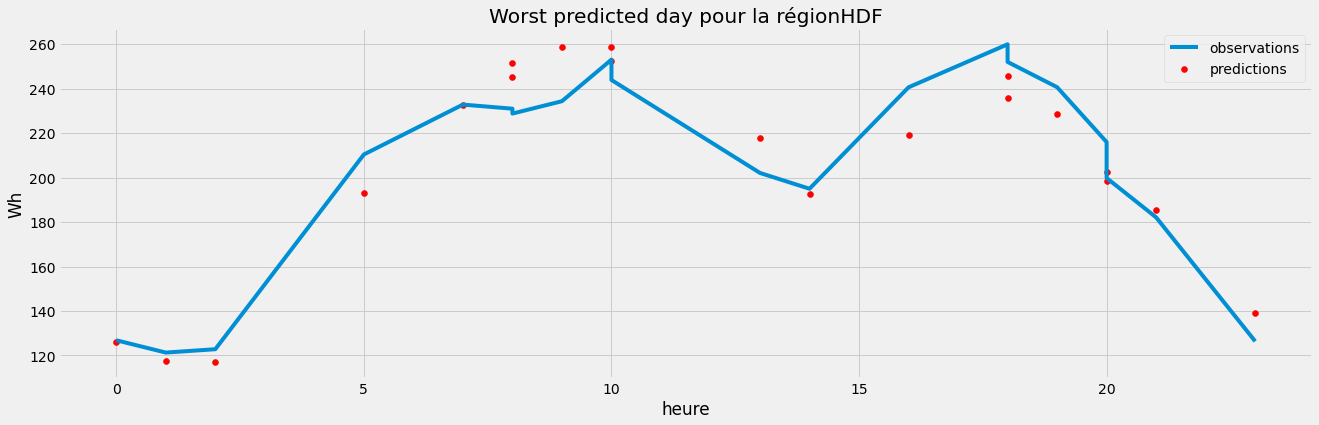

In [303]:
xg_boost_molaire(enedis_HDF_train,enedis_HDF_test,"HDF")

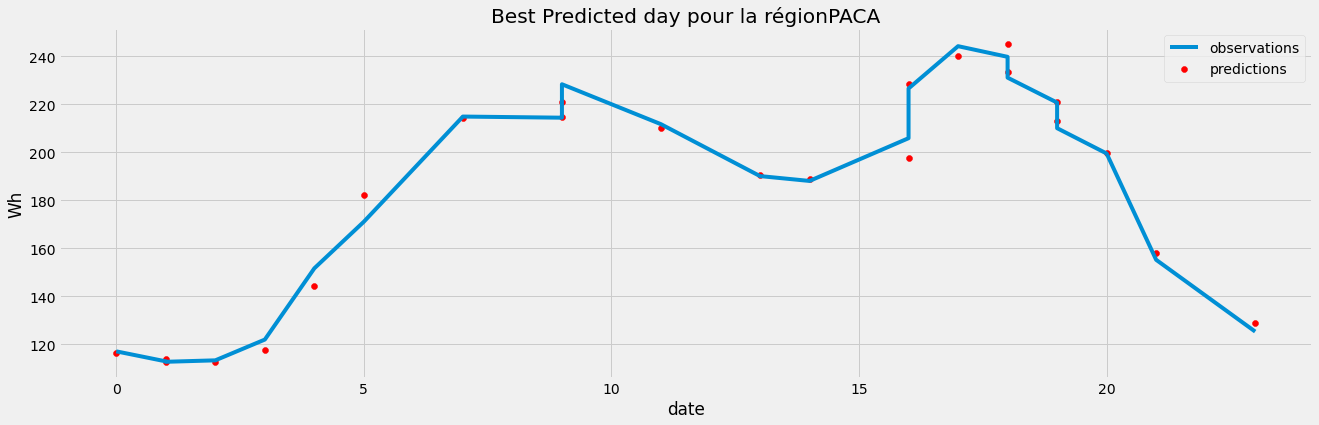

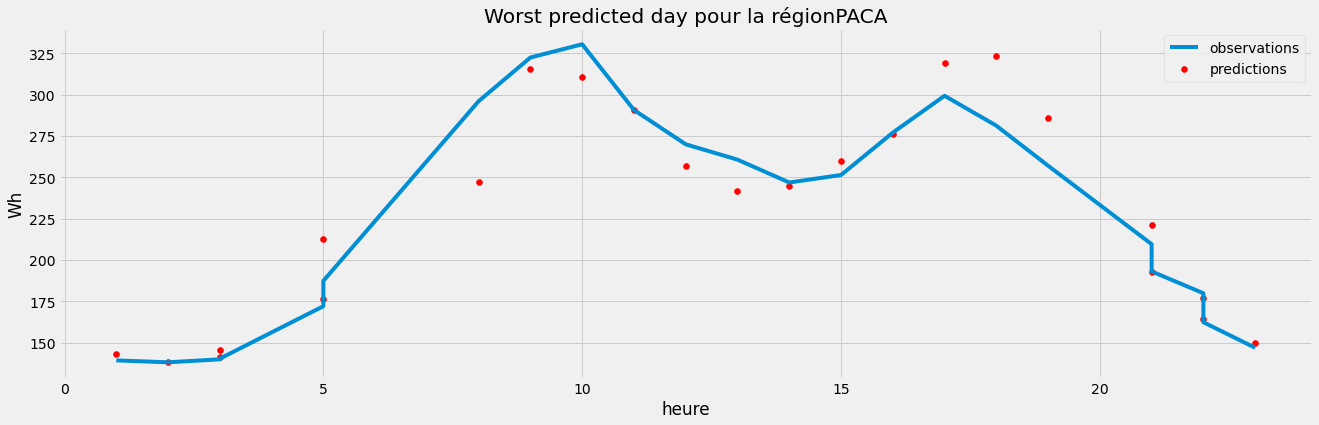

In [304]:
xg_boost_molaire(enedis_PACA_train,enedis_PACA_test,"PACA")

In [305]:
def xg_boost_first_week(df_test,nom_court):
    df_test = df_test.reset_index()
    df_test_first_week = df_test[df_test["weekofyear"]==df_test["weekofyear"][0]]
    plt.figure(figsize=(20,6))
    plt.plot(df_test_first_week["horodate"],df_test_first_week["res_conso_moyenne"],label="Observation")
    plt.scatter(df_test_first_week["horodate"],df_test_first_week["Conso_prediction"],color="red",label="prediction")
    plt.xlabel("Jour")
    plt.ylabel("Wh")
    plt.title("Prévision vs Actuelle Semaine de Juin 2021 pour la region"+nom_court)



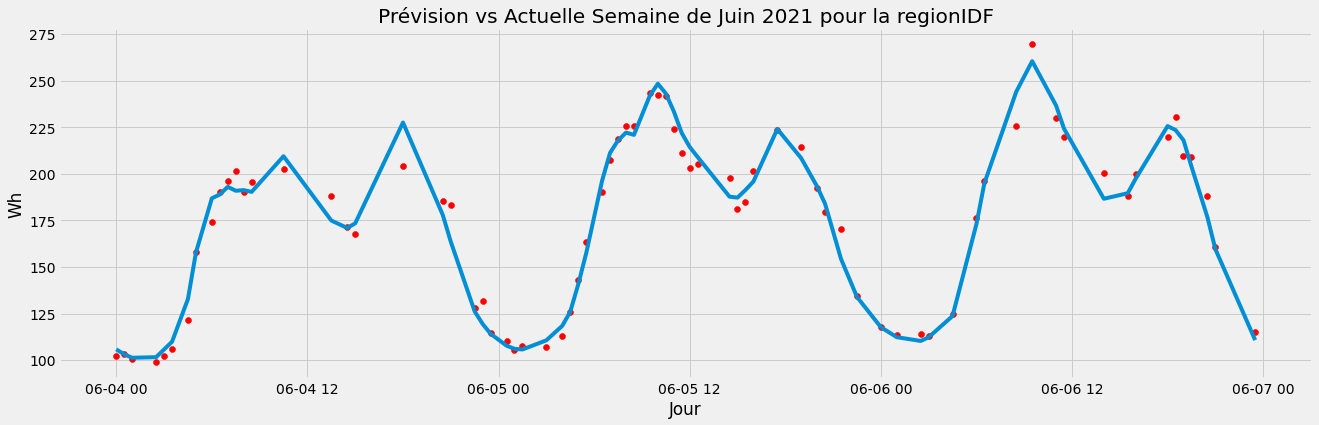

In [306]:
xg_boost_first_week(enedis_IDF_test,"IDF")

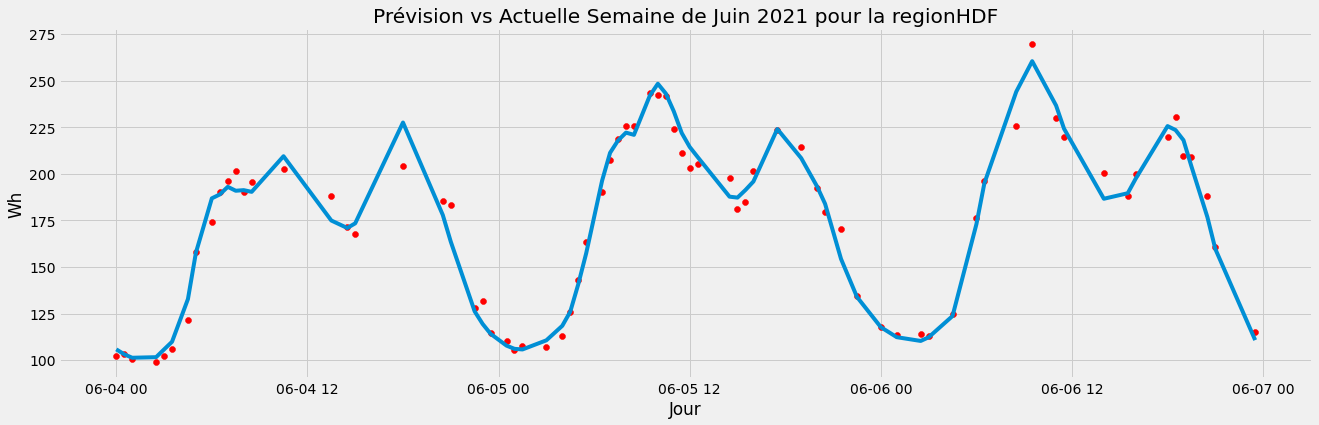

In [307]:
xg_boost_first_week(enedis_IDF_test,"HDF")

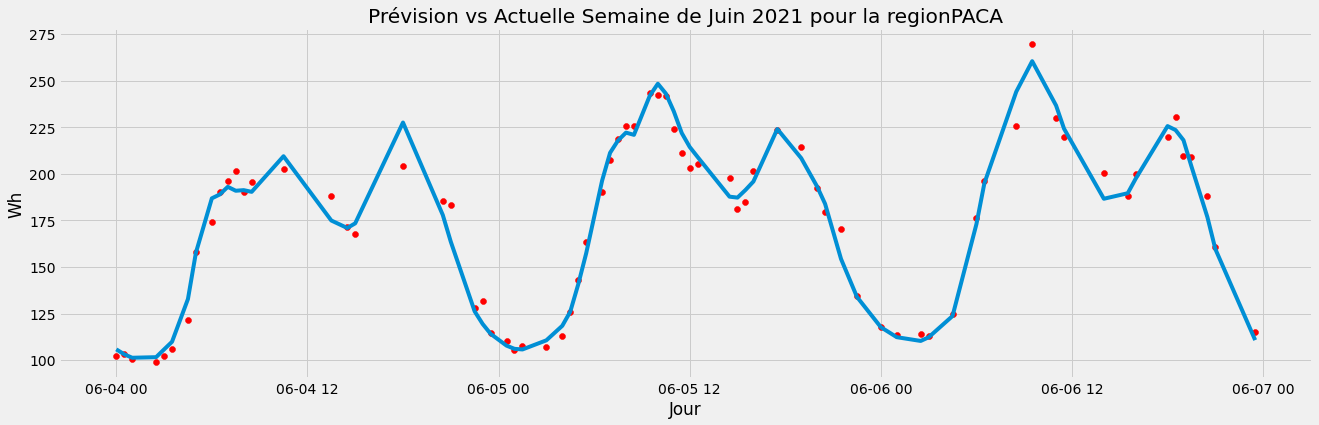

In [308]:
xg_boost_first_week(enedis_IDF_test,"PACA")

In [309]:
def xg_boost_first_month(df_test,nom_court):
    df_test = df_test.reset_index()
    df_test_first_week = df_test[df_test["month"]==df_test["month"][0]]
    plt.figure(figsize=(40,6))
    plt.plot(df_test_first_week["horodate"],df_test_first_week["res_conso_moyenne"],label="Observation")
    plt.scatter(df_test_first_week["horodate"],df_test_first_week["Conso_prediction"],color="red",label="prediction")
    plt.xlabel("Jour")
    plt.ylabel("Wh")
    plt.title("Prévision vs Actuelle Juin 2021 pour la region"+nom_court)


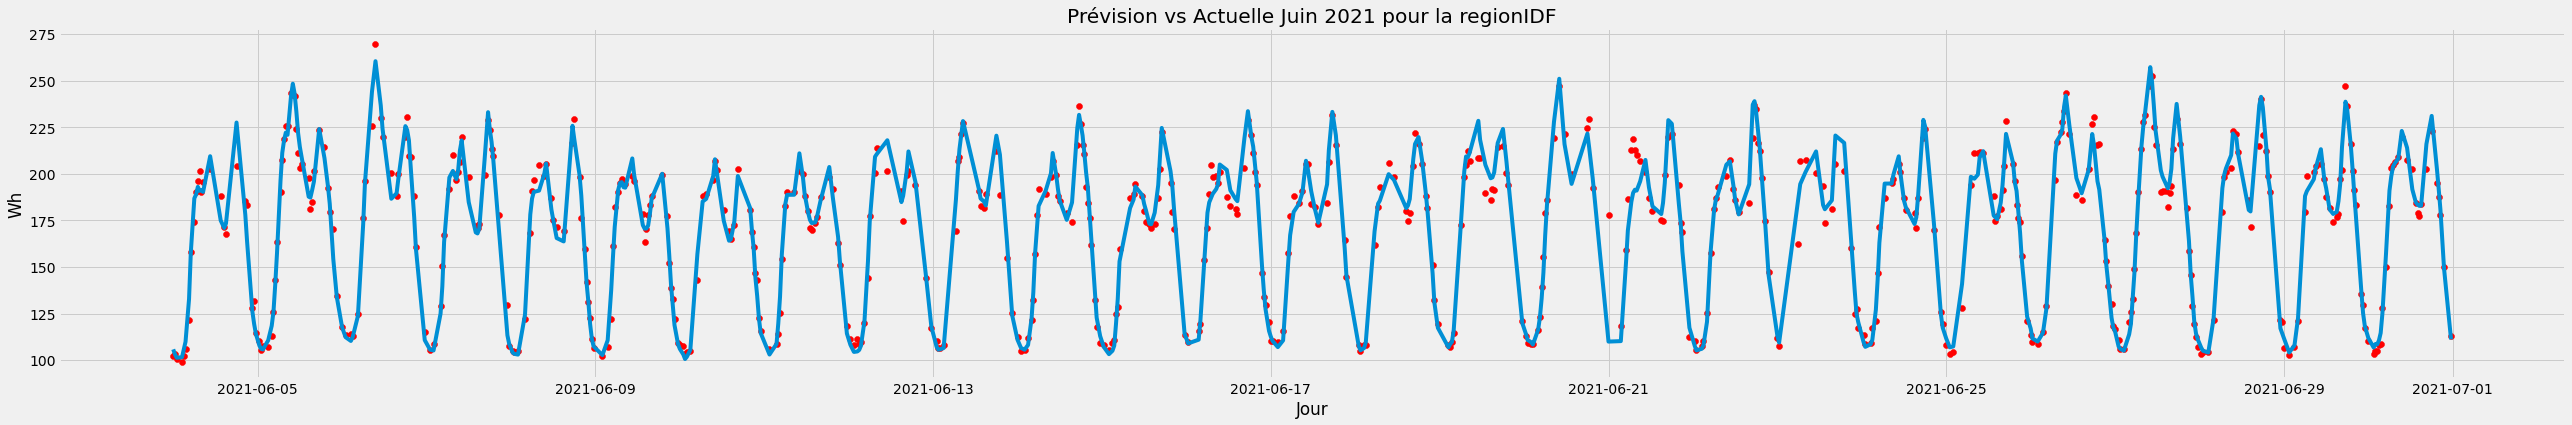

In [311]:
xg_boost_first_month(enedis_IDF_test,"IDF")

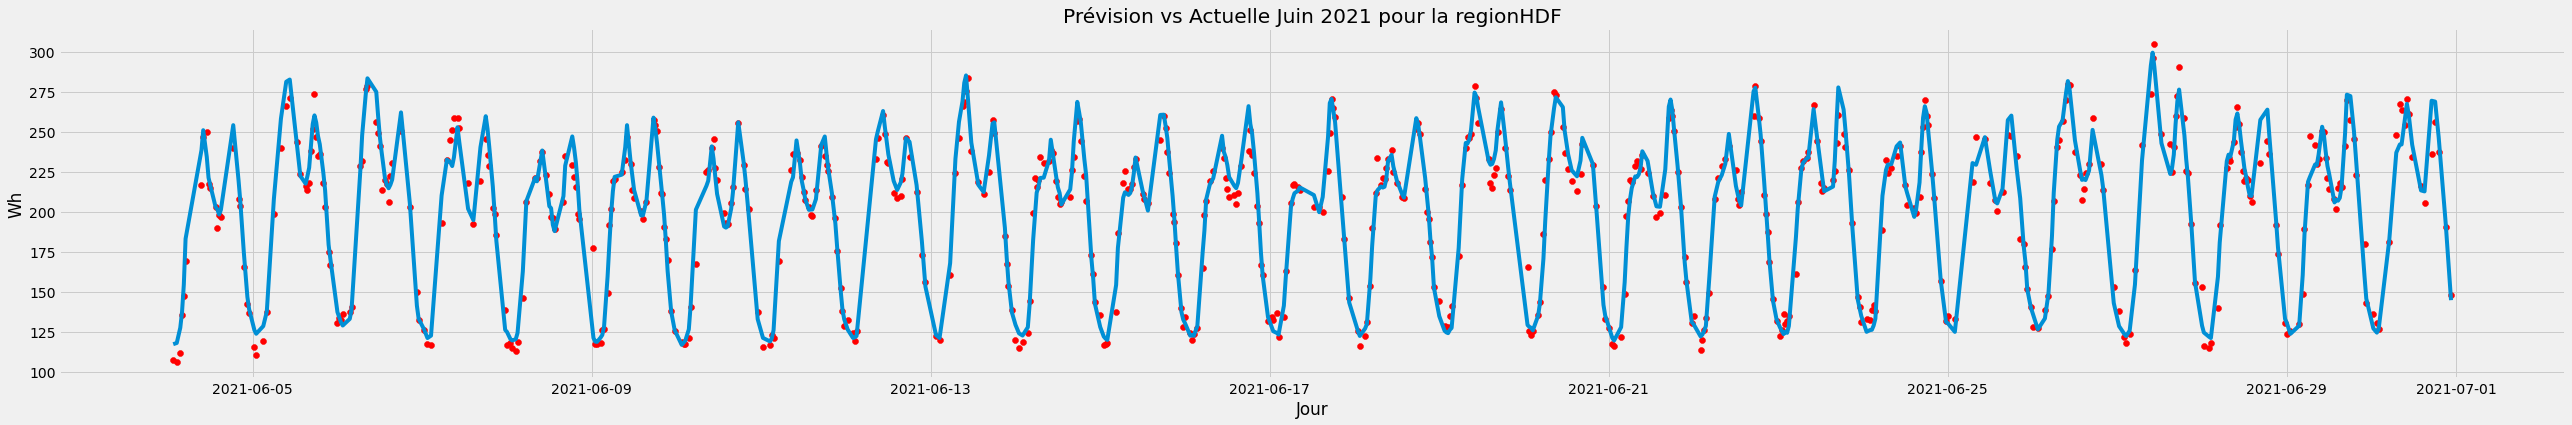

In [312]:
xg_boost_first_month(enedis_HDF_test,"HDF")

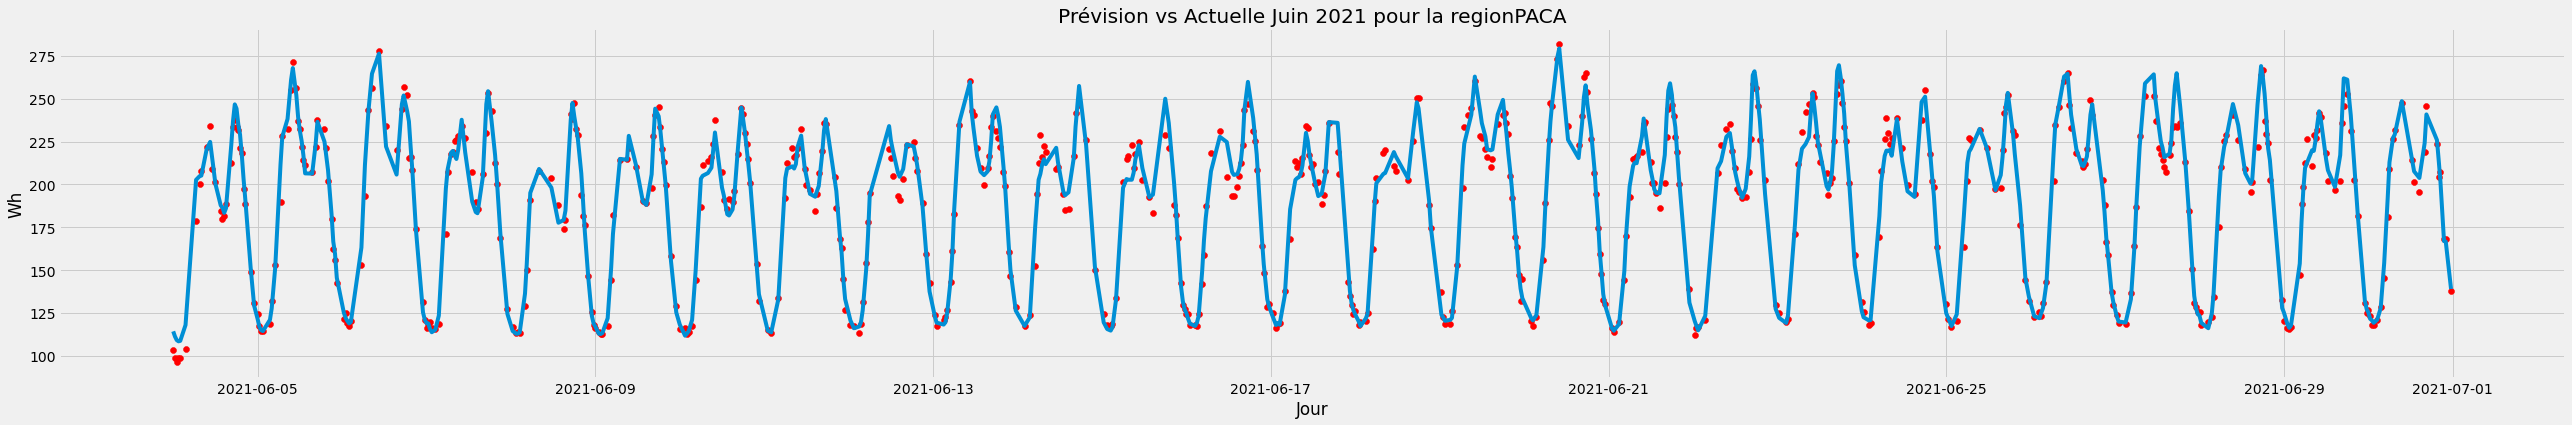

In [313]:
xg_boost_first_month(enedis_PACA_test,"PACA")

## Optimisation du modèle XGboost

## Optimisation des features 

In [290]:
from sklearn.feature_selection import RFE

# Train the XGBoost model
model = xgb.XGBRegressor()
model.fit(X_IDF_train, y_IDF_train)

# Perform recursive feature elimination
rfe = RFE(model, n_features_to_select=8)
X_IDF_train_rfe = rfe.fit_transform(X_IDF_train, y_IDF_train)
X_IDF_test_rfe = rfe.transform(X_IDF_test)

# Train the XGBoost model on the selected features
model_rfe = xgb.XGBRegressor()
model_rfe.fit(X_IDF_train_rfe, y_IDF_train)

# Evaluate the performance of the model on the test set
score = model_rfe.score(X_IDF_test_rfe, y_IDF_test)
print('Model score on test set: {}'.format(score))

Model score on test set: 0.967523204912685


In [319]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Créer un modèle XGBoost
model = XGBRegressor()

# Définir les paramètres à tester
params = {
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6,8,15],
    'n_estimators': [100, 200, 300, 400,700,100]
}

# Effectuer une recherche de grille pour trouver les meilleurs paramètres
grid = GridSearchCV(model, params, cv=5)
grid.fit(X_IDF_train, y_IDF_train)

# Afficher les meilleurs paramètres
print(grid.best_params_)